# Entrainement d'un Processus Gaussien "maison" avec tf.distribution.MVN

On veut vérifier que l'on sait entraîner proprement un processus Gaussien "à la main" en encodant une tf.distribution.MVN et en apprenant les paramètres du kernel par maximisation du likelihood

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from gpvae_lib import GPNullMean, CauchyKernel, GaussianKernel

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


In [4]:
n_steps = 50
n_ahead = 50
n_series = 10000

def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.4 * np.sin((time - o1) * (f1 * 5 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o2) * (f2 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [5]:
s = generate_time_series(n_series, n_steps+n_ahead)

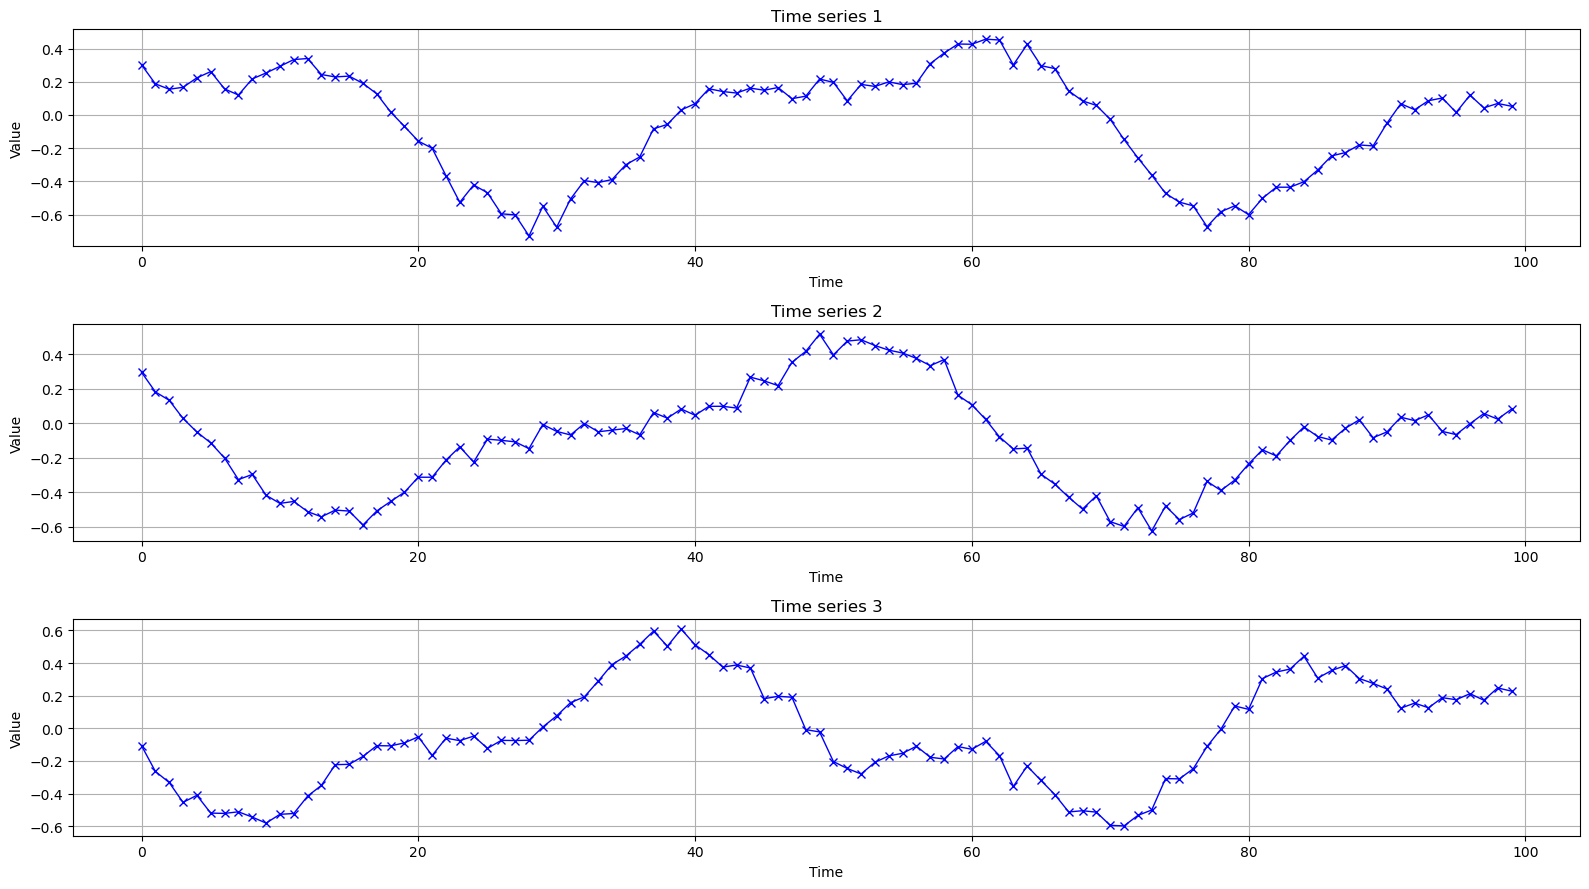

In [6]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [7]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (8000, 50)
y_train shape: (8000, 50)
X_valid shape: (2000, 50)
y_valid shape: (2000, 50)


In [8]:
# form datasets, dataloaders, etc

BATCH_SIZE = 16  # 8192 ok sur RTX3080 et 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## On apprend le PG sur une time serie

In [96]:
mean = GPNullMean()
# kernel = GaussianKernel(lengthscale=1.0, variance=1.0)
kernel = CauchyKernel(lengthscale=1.0, variance=1.0)

In [97]:
# simple sinusoïde
N_POINTS = 100
times = torch.linspace(0, 1, N_POINTS).unsqueeze(0).to(device)
targets = torch.sin(2 * torch.pi * times).to(device)

In [98]:
# sinusoïdes liées

# targets = torch.tensor(X_train[0]).to(device).unsqueeze(0)  # shape (1, n_steps)
# times = torch.linspace(0, targets.size(-1)-1, n_steps).to(device).unsqueeze(0)  # shape (1, n_steps)

In [99]:
# learnable parameters : kernel parameters only
optimizer = torch.optim.Adam(kernel.parameters(), lr=1e-3)

In [100]:
# Train the GP model to get the kernel parameters

n_epochs = int(1e+4)  # number of epochs for training
kernel.train()  # set the kernel in training mode
losses = []  # to store the losses
lengthscales = []  # to store the lengthscales
variances = []  # to store the variances

for epoch in range(n_epochs):  # number of epochs

    # compute the mean of the GP
    loc = mean(times)  # (1, N)

    # compute the covariance matrix of the GP
    covar, L = kernel(times, times)  # (1, N, N)

    # check
    assert L is not None, "Cholesky decomposition failed, L should not be None."

    # instantiate the GP prior with the lower traingular matrix L from Cholesky decomposition
    gp = torch.distributions.MultivariateNormal(loc, scale_tril=L)

    # compute the log likelihood of the GP prior
    log_likelihood = gp.log_prob(targets)  # (1,)

    # get the loss
    loss = -log_likelihood.mean()  # mean over the batch
    
    # backpropagation
    optimizer.zero_grad()  # zero the gradients
    loss.backward()  # backpropagation
    optimizer.step()  # update the parameters
    
    # report out metrics
    losses.append(loss.item())
    lengthscales.append(kernel.lengthscale.item())
    variances.append(kernel.variance.item())
    
    print(f"Epoch {epoch+1:>5}/{n_epochs:>5}, Loss: {loss.item():.4f}, Lengthscale: {kernel.lengthscale.item():.4f}, Variance: {kernel.variance.item():.4f}")

Epoch     1/10000, Loss: -179.6263, Lengthscale: 0.9990, Variance: 1.0010
Epoch     2/10000, Loss: -179.9268, Lengthscale: 0.9980, Variance: 1.0020
Epoch     3/10000, Loss: -180.2254, Lengthscale: 0.9970, Variance: 1.0030
Epoch     4/10000, Loss: -180.5220, Lengthscale: 0.9960, Variance: 1.0040
Epoch     5/10000, Loss: -180.8166, Lengthscale: 0.9950, Variance: 1.0050
Epoch     6/10000, Loss: -181.1093, Lengthscale: 0.9940, Variance: 1.0060
Epoch     7/10000, Loss: -181.3999, Lengthscale: 0.9930, Variance: 1.0070
Epoch     8/10000, Loss: -181.6885, Lengthscale: 0.9920, Variance: 1.0080
Epoch     9/10000, Loss: -181.9750, Lengthscale: 0.9910, Variance: 1.0090
Epoch    10/10000, Loss: -182.2594, Lengthscale: 0.9900, Variance: 1.0100
Epoch    11/10000, Loss: -182.5418, Lengthscale: 0.9890, Variance: 1.0110
Epoch    12/10000, Loss: -182.8221, Lengthscale: 0.9880, Variance: 1.0120
Epoch    13/10000, Loss: -183.1003, Lengthscale: 0.9870, Variance: 1.0130
Epoch    14/10000, Loss: -183.3763, Le

In [101]:
# compute predictions
N_POINTS = 1000  # number of points to predict
TIMES = 2  # nombre d'intervalles au-delà des données d'entraînement

all_times = torch.linspace(0, 1 * TIMES, N_POINTS).to(device).unsqueeze(0)  # shape (1, n_steps)

k_1_1, _ = kernel(times, times)  # (1, N, N)
k_2_1, _ = kernel(all_times, times)  # (1, N_POINTS, N)
k_1_2 = k_2_1.transpose(-1, -2)  # (1, N, N_POINTS)
k_2_2, _ = kernel(all_times, all_times)  # (1, N_POINTS, N_POINTS)

posterior_mean = k_2_1 @ (torch.linalg.inv(k_1_1) @ targets.unsqueeze(-1))  # (1, N_POINTS)
posterior_cov = k_2_2 - k_2_1 @ torch.linalg.solve(k_1_1, k_1_2)  # (1, N_POINTS, N_POINTS)

# instantiate the GP posterior with the posterior mean and covariance
gp_posterior = torch.distributions.MultivariateNormal(posterior_mean.squeeze(-1), scale_tril=torch.linalg.cholesky(posterior_cov))

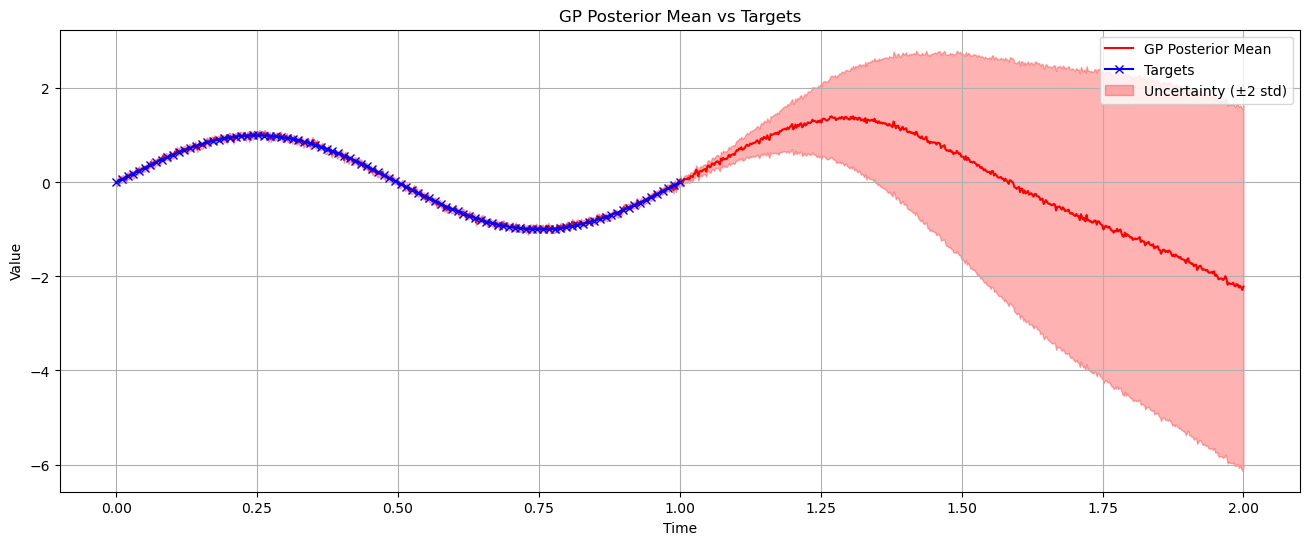

In [102]:
# sample from the posterior and display the predictions

preds = gp_posterior.sample()  # (1, N_POINTS)

fig, axs = plt.subplots(1, 1, figsize=(16, 6))

axs.plot(all_times.cpu().numpy().squeeze(), preds.squeeze().detach().cpu().numpy(), color='red', label='GP Posterior Mean')
axs.plot(times.cpu().numpy().squeeze(), targets.cpu().numpy().squeeze(), color='blue', marker='x', label='Targets')
axs.fill_between(all_times.cpu().numpy().squeeze(),
                 (preds.squeeze().detach().cpu().numpy() - 2 * np.sqrt(torch.diagonal(posterior_cov, dim1=-2, dim2=-1).squeeze().detach().cpu().numpy())),
                 (preds.squeeze().detach().cpu().numpy() + 2 * np.sqrt(torch.diagonal(posterior_cov, dim1=-2, dim2=-1).squeeze().detach().cpu().numpy())),
                 color='red', alpha=0.3, label='Uncertainty (±2 std)')
plt.legend()
plt.title("GP Posterior Mean vs Targets")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()